In [98]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random

from models import create_model

# EXPLORE DATA
Initially lets see what out data looks like. It is images and csv file with masks on it.

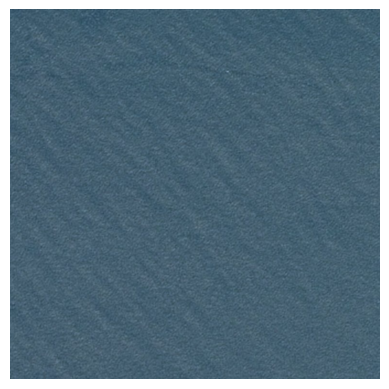

In [99]:
def select_random_files(path: str, n:int):
    file_list = []
    entries = os.listdir(path)
    random_entries = random.sample(entries, n)

    for entry in random_entries:
        file_list.append(os.path.join(path, entry))

    return np.stack(file_list)

imgs = select_random_files("data/airbus-ship-detection/train_v2", 1)
img_example = cv2.imread(imgs[0])
plt.imshow(cv2.cvtColor(img_example, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

We can see that number of images without ships are 3+ times more that with at least one ship on it. For training out model that will badly influence performance. So, as data preprocessing steps let's. Add ships counter to dataset for easiear data manipulation. Next as we see from plots dataset is highly imbalanced, so we need to reduce number of images without ships. And finally plots with splited data train and validation.

In [100]:
train_masks = pd.read_csv("data/airbus-ship-detection/train_ship_segmentations_v2.csv")
print(f'Training dataset contains {len(train_masks)} samples')

with_ships = train_masks[~train_masks.EncodedPixels.isna()].ImageId.unique()
without_ships = train_masks[train_masks.EncodedPixels.isna()].ImageId.unique()

print(len(with_ships), len(without_ships))

Training dataset contains 231723 samples
42556 150000


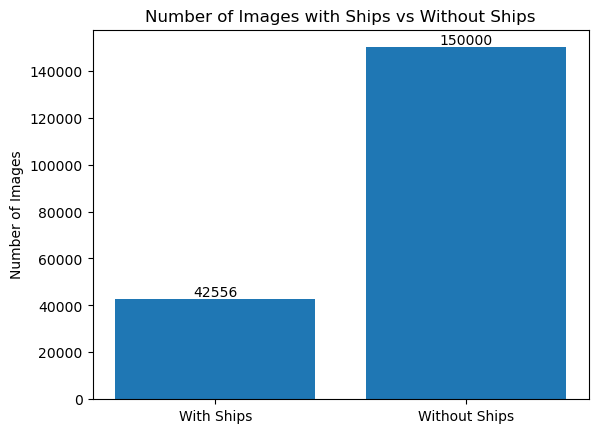

In [101]:
def visualize_if_ship():
    # Create a bar plot
    fig, ax = plt.subplots()
    ax.bar(['With Ships', 'Without Ships'], [len(with_ships), len(without_ships)])
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images with Ships vs Without Ships')

    # Add labels on top of each bar
    for i, v in enumerate([len(with_ships), len(without_ships)]):
        ax.text(i, v, str(v), ha='center', va='bottom')

    plt.show()
visualize_if_ship()

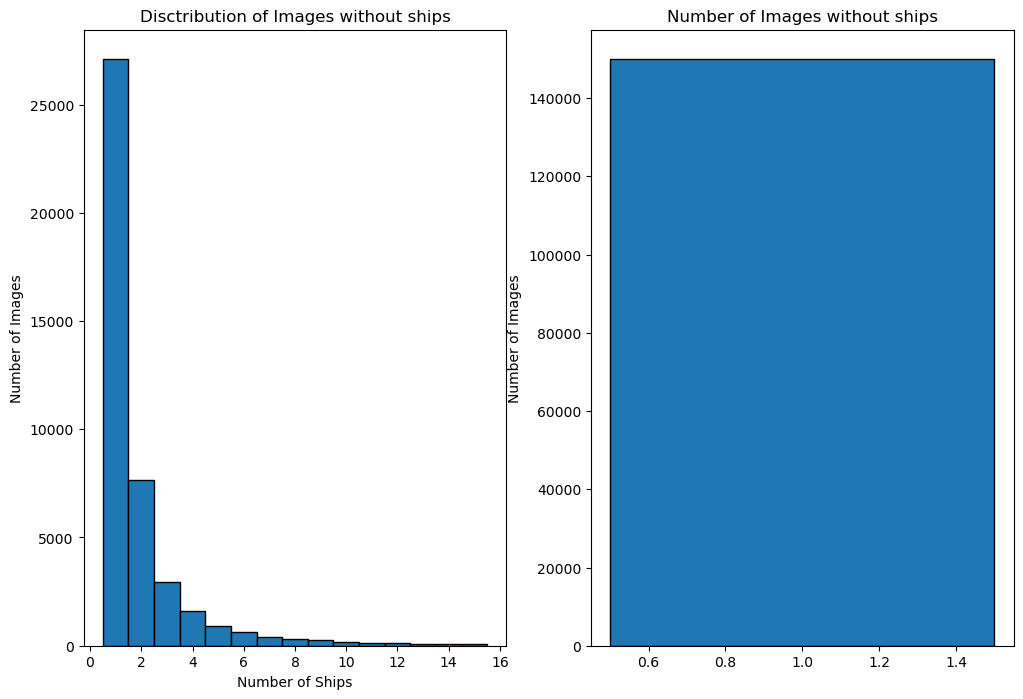

In [102]:
def visualize_ships_amount(data, ships_on_image=True):
    # Count the number of images with ships for each unique image identifier
    ship_counts_ships = data[data.ImageId.isin(with_ships)].groupby('ImageId').size()
    ship_counts_no_ships = data[data.ImageId.isin(without_ships)].groupby('ImageId').size()
    # Plot the distribution of images with ships
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    ax[0].hist(ship_counts_ships, bins=range(1, max(ship_counts_ships)+2), align='left', edgecolor='black')
    ax[0].set_xlabel('Number of Ships')
    ax[0].set_ylabel('Number of Images')
    ax[0].set_title('Disctribution of Images without ships')
    ax[1].hist(ship_counts_no_ships, bins=range(1, max(ship_counts_no_ships)+2), align='left', edgecolor='black')
    ax[1].set_ylabel('Number of Images')
    ax[1].set_title('Number of Images without ships')
    # plt.xticks(range(1, max(ship_counts_no_ships)+1))
    plt.show()

visualize_ships_amount(train_masks)

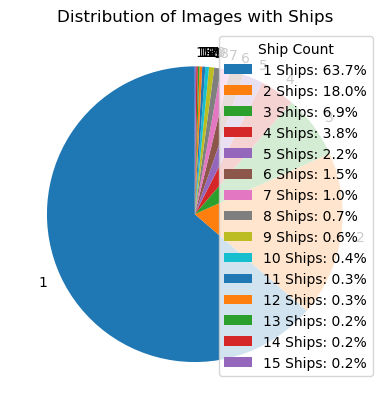

In [103]:
def visualize_ships_pie():
    # Count the number of images with ships for each unique image identifier
    ship_counts = train_masks[train_masks.ImageId.isin(with_ships)].groupby('ImageId').size()

    # Count the occurrences of each ship count
    count_counts = ship_counts.value_counts().sort_index()

    # Plot the distribution of images with ships as a pie chart
    plt.pie(count_counts, labels=count_counts.index, startangle=90)

    # Add a custom legend with the percentage for each ship count
    total = sum(count_counts)
    percentages = [f'{count/total*100:.1f}%' for count in count_counts]
    plt.legend(title='Ship Count', labels=[f'{i} Ships: {p}' for i, p in zip(count_counts.index, percentages)], loc='upper right')

    # Set the title
    plt.title('Distribution of Images with Ships')
    # Display the pie chart
    plt.show()

visualize_ships_pie()

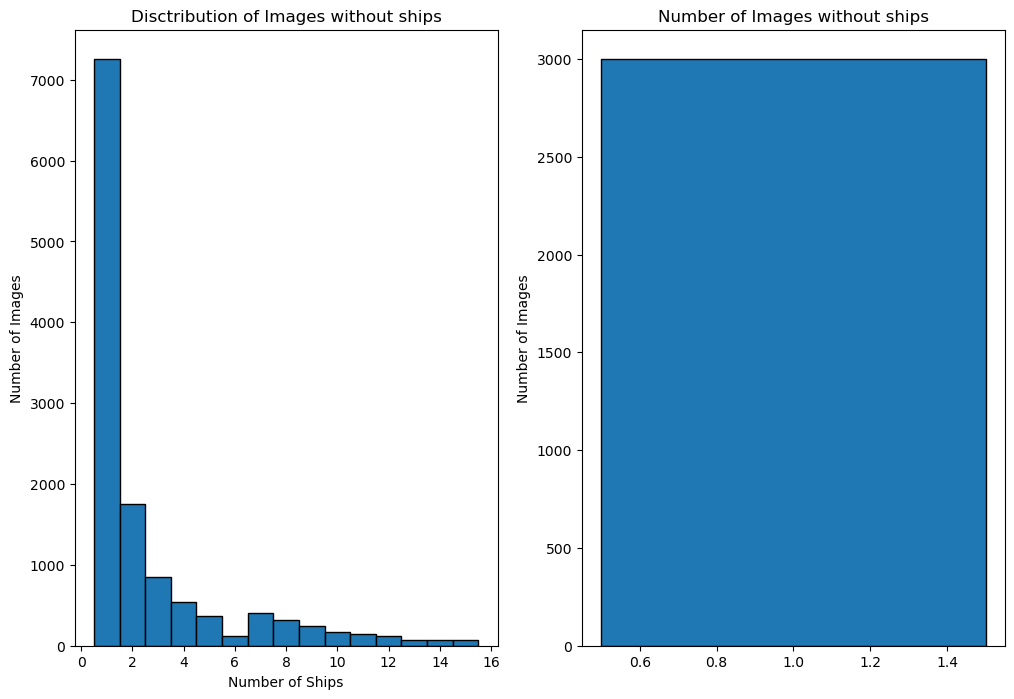

In [104]:
train_masks_balanced = pd.read_csv("data/balanced.csv")

visualize_ships_amount(train_masks_balanced)

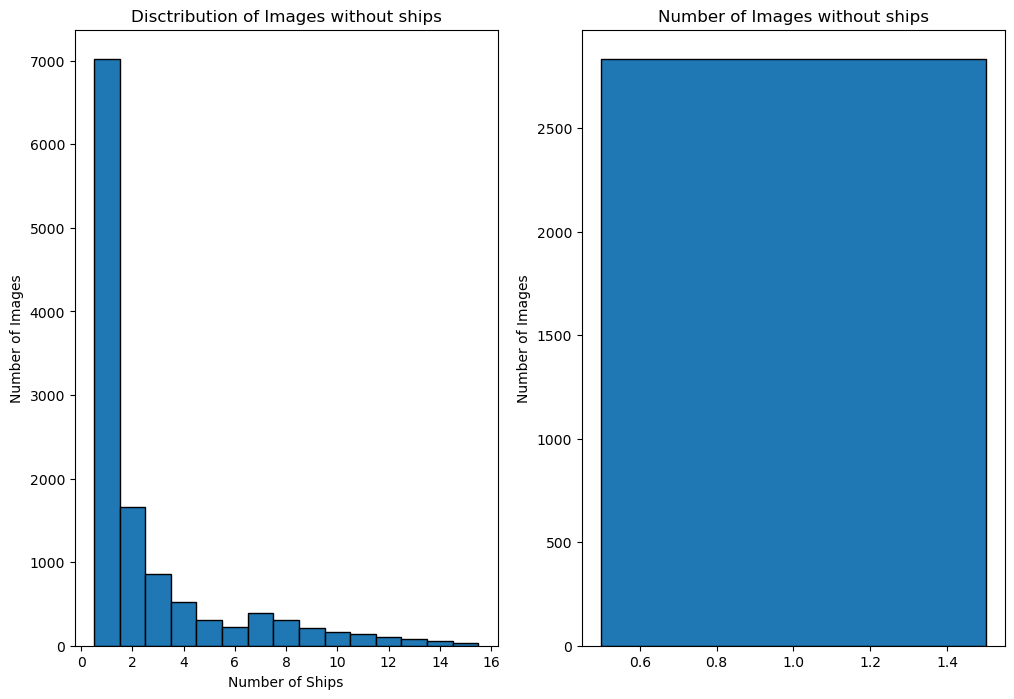

In [105]:
train_masks_balanced_split = pd.read_csv("data/train_df.csv")
visualize_ships_amount(train_masks_balanced_split)

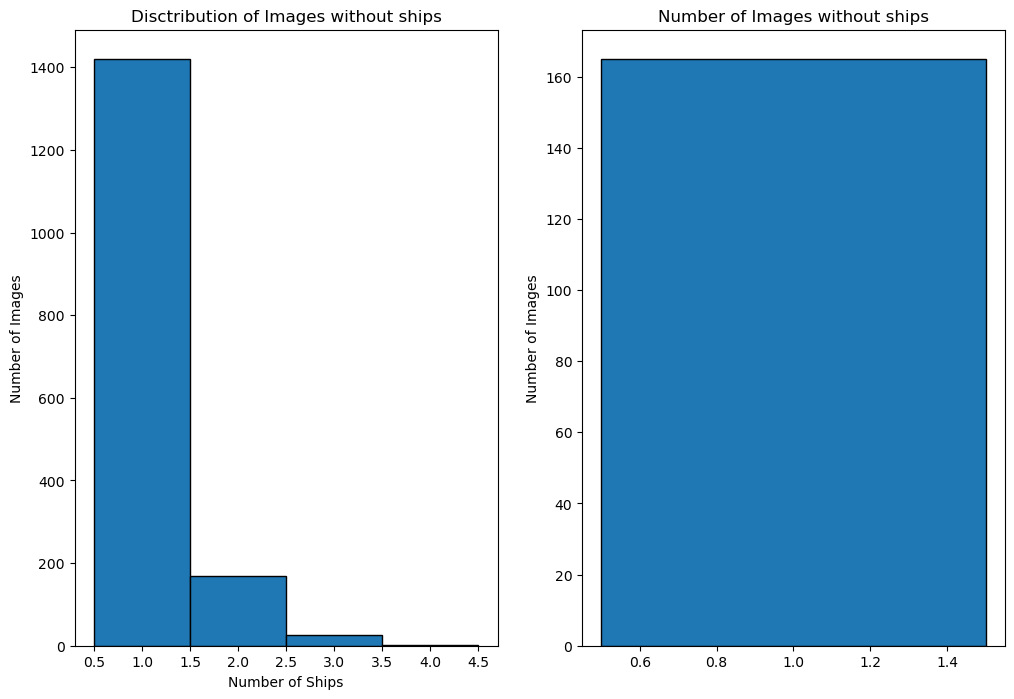

In [106]:
validation_masks_balanced_split = pd.read_csv("data/val_df.csv")
visualize_ships_amount(validation_masks_balanced_split)

# TEST TRAINED MODEL


After training UNET on smaler resolution due to improving speed of training and again upsampling results to size of original images let's check the perforamce of model on dice score (metric for image segmentation problem)

In [115]:
def read_img(filename: str) -> np.ndarray:
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return np.float32(image / 255)

In [146]:
imgs_test = select_random_files("data/airbus-ship-detection/test_v2", 10)
images_readed = []

for entry in imgs_test:
    images_readed.append(read_img(entry))

images_readed = np.stack(images_readed)


In [117]:
def plot_helper(ax:any, indx:int, title_name:str):
    ax[indx].set_title(title_name, fontsize=14)
    ax[indx].axis('off')
    ax[indx].grid(False)

In [147]:
model = create_model.U_NET_fullresolution(1,True)
model.load_weights("models/weights_unet.h5")
masks = model(images_readed, training=False)

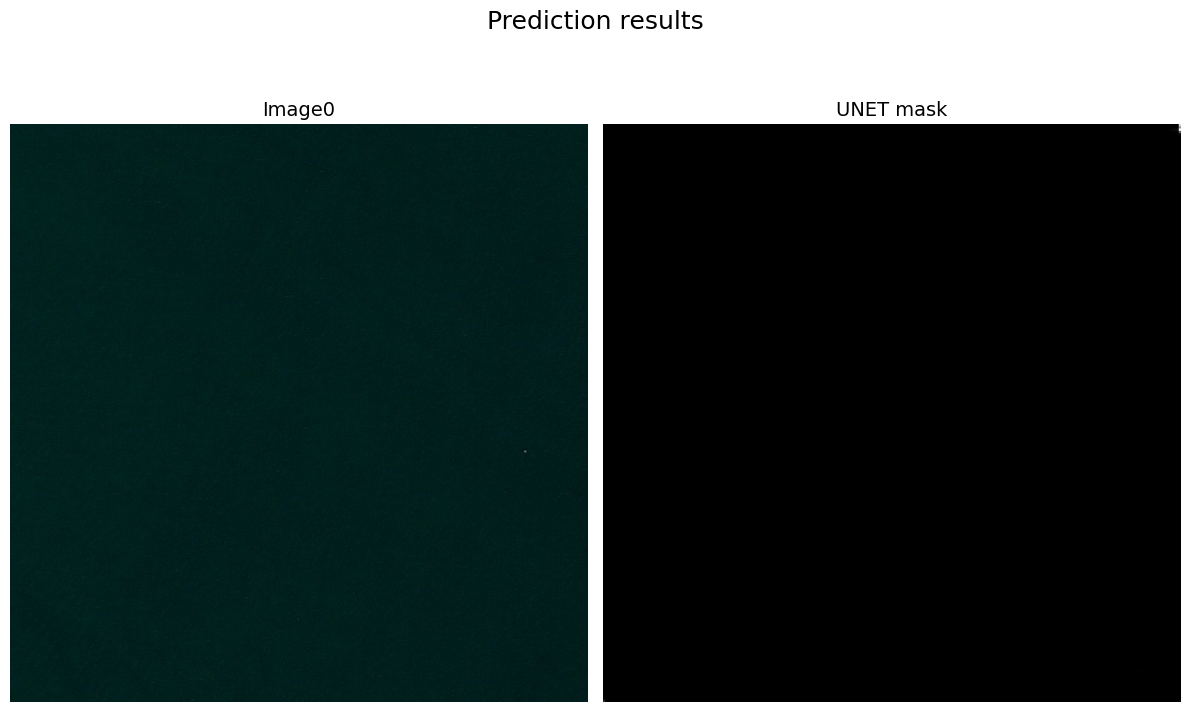

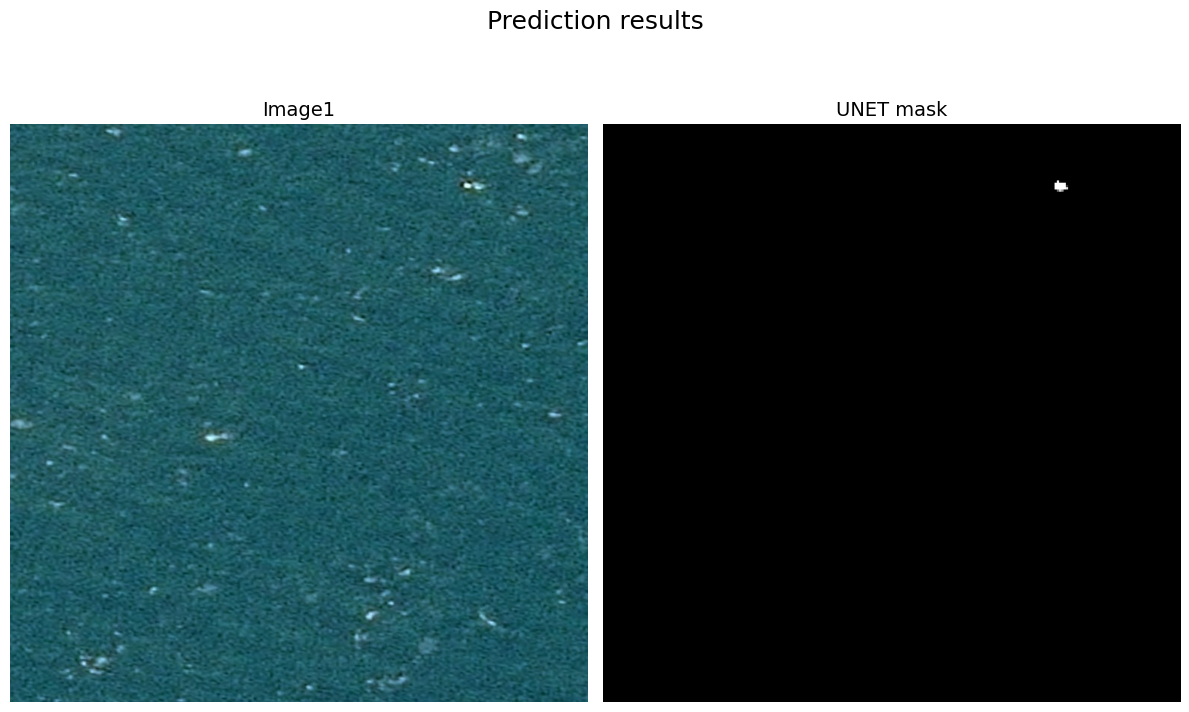

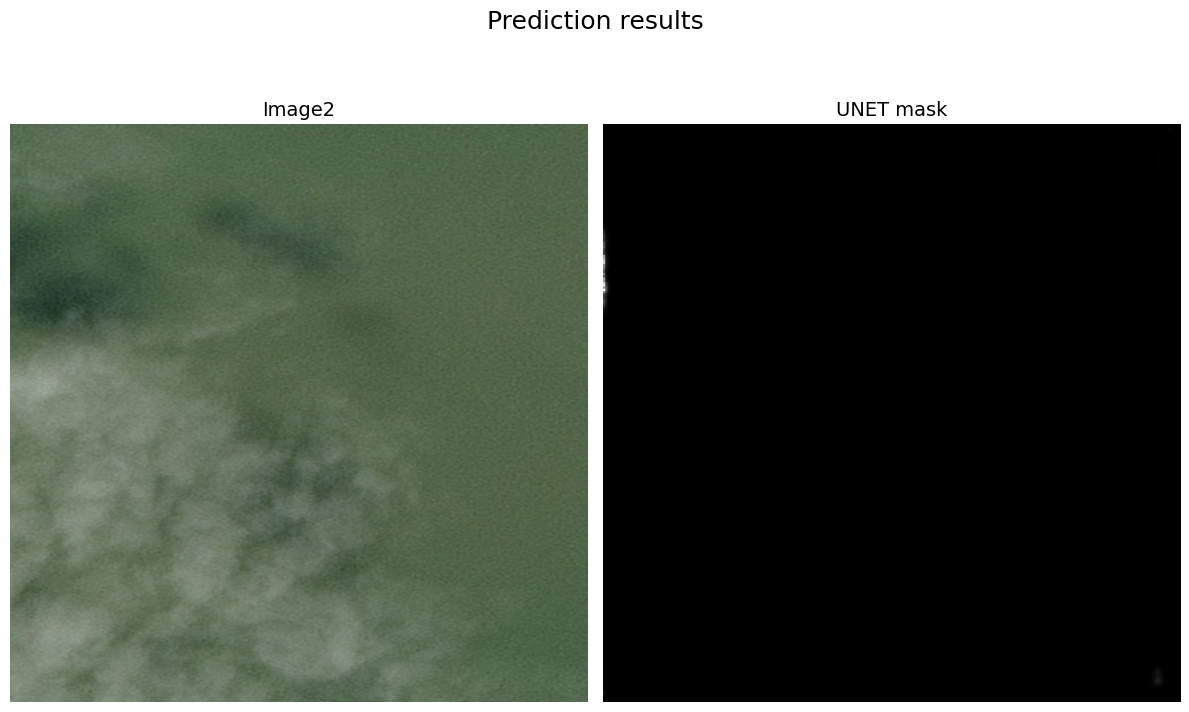

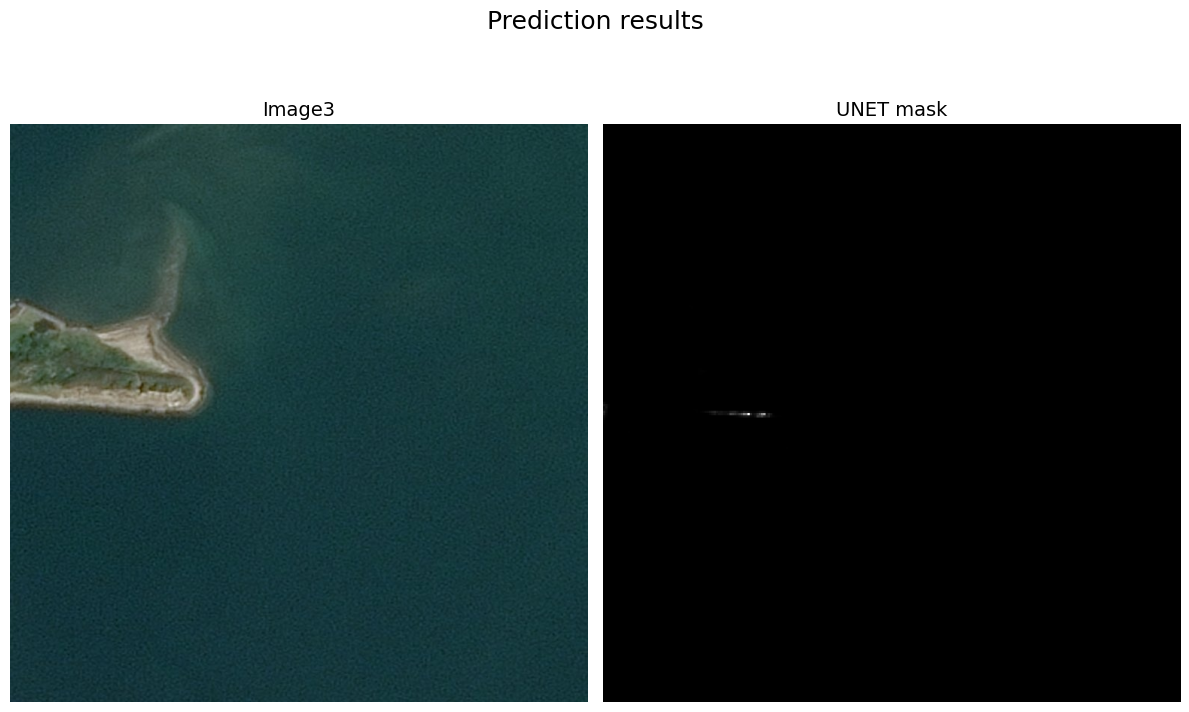

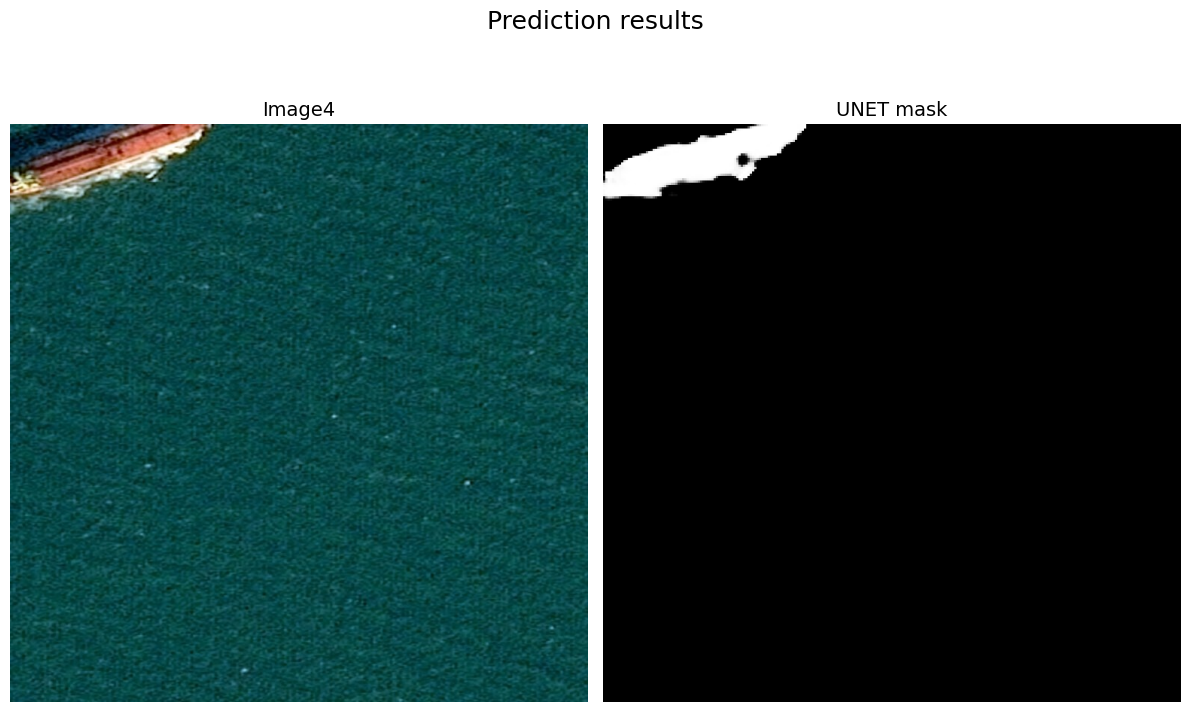

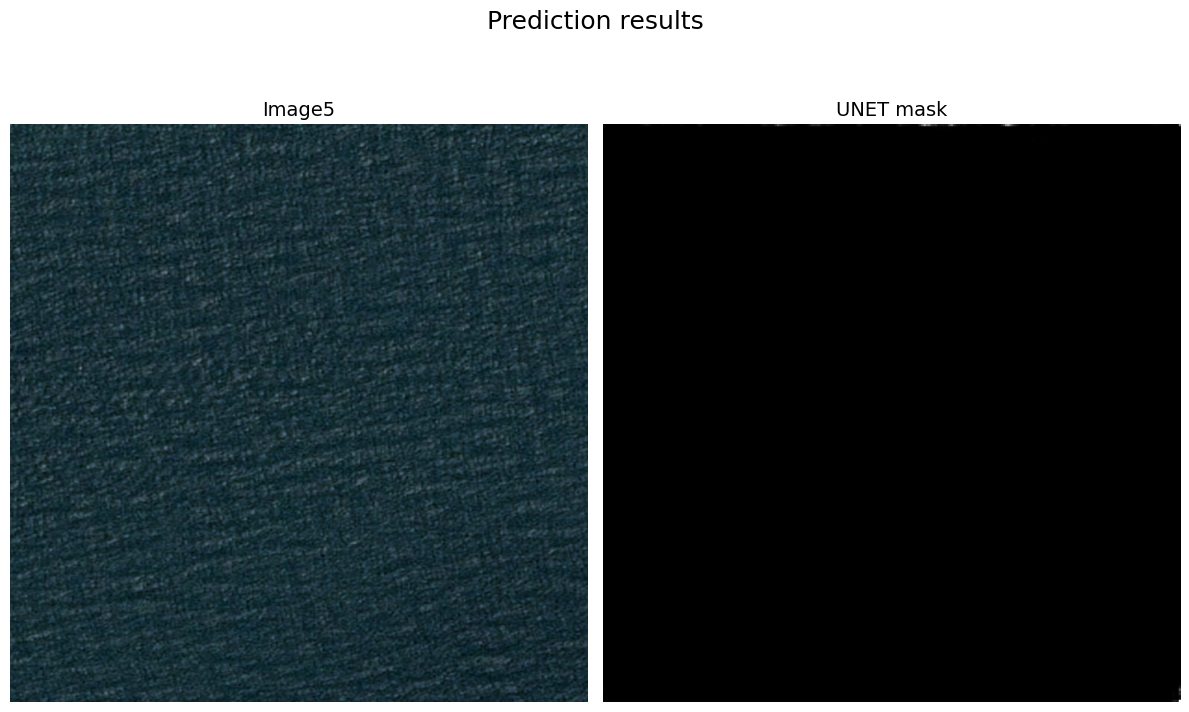

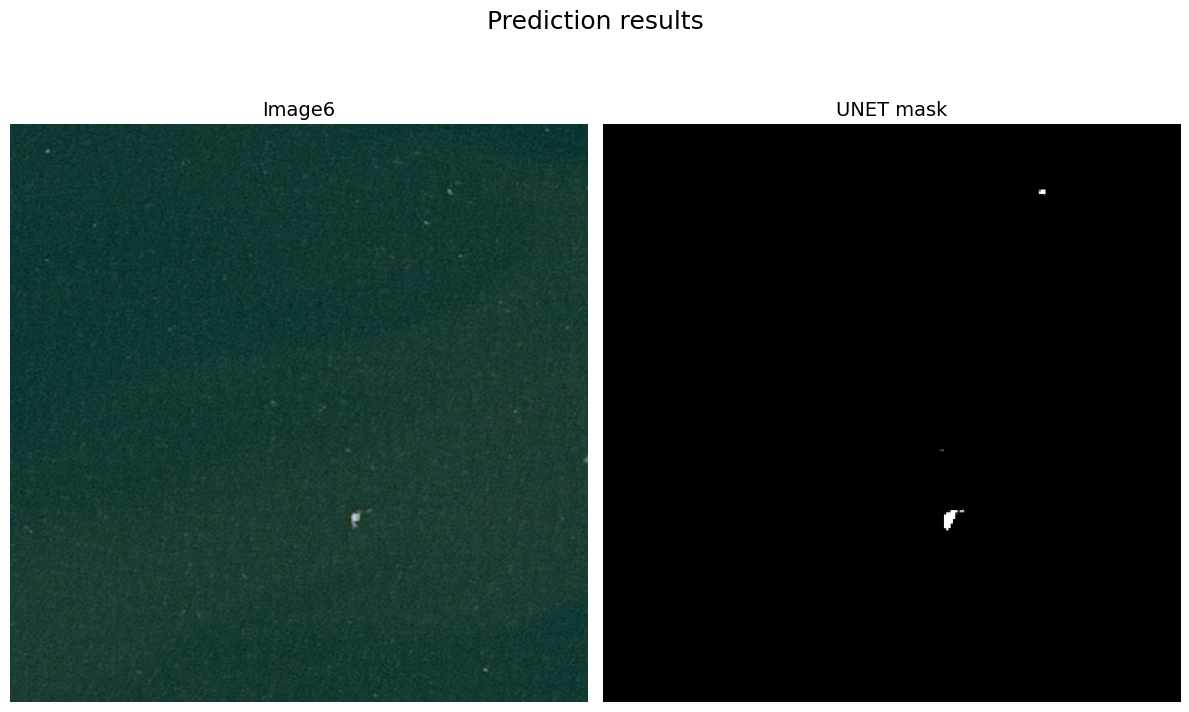

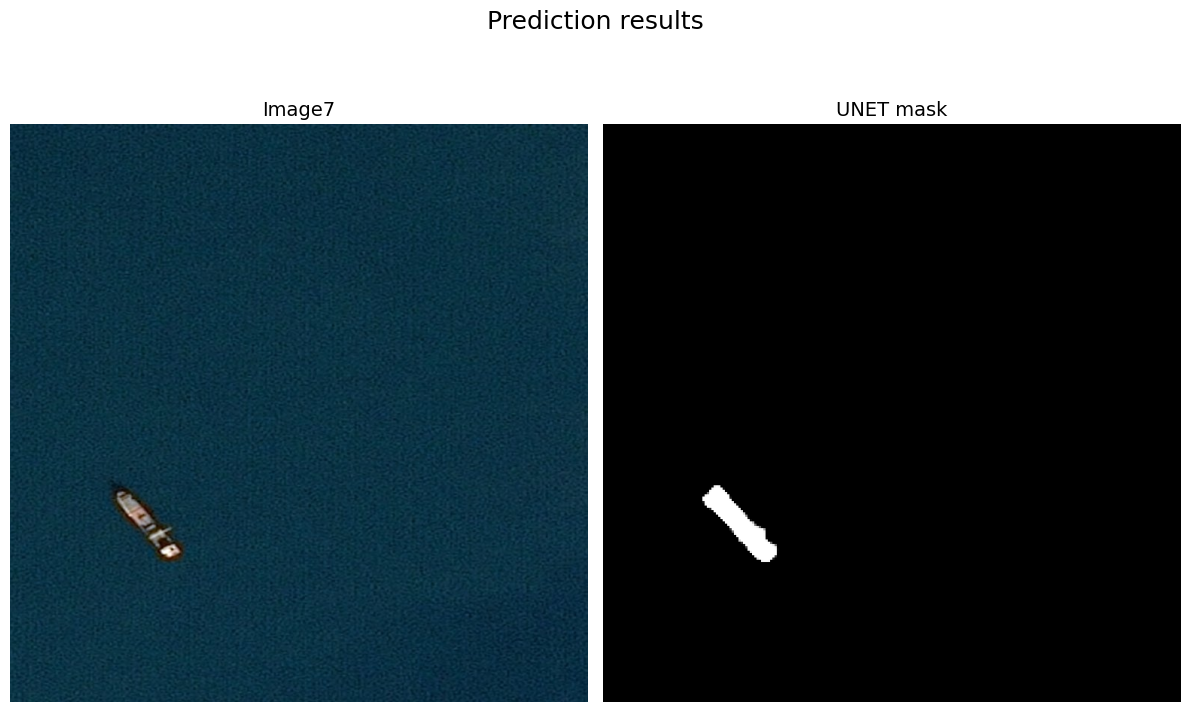

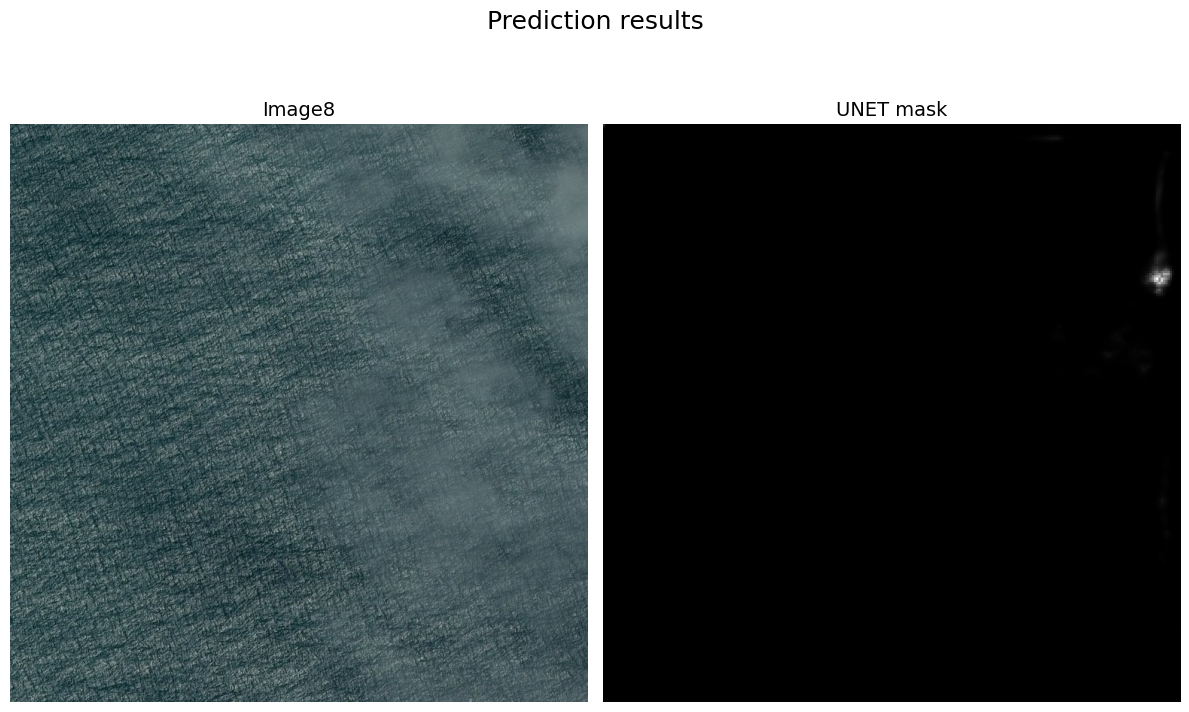

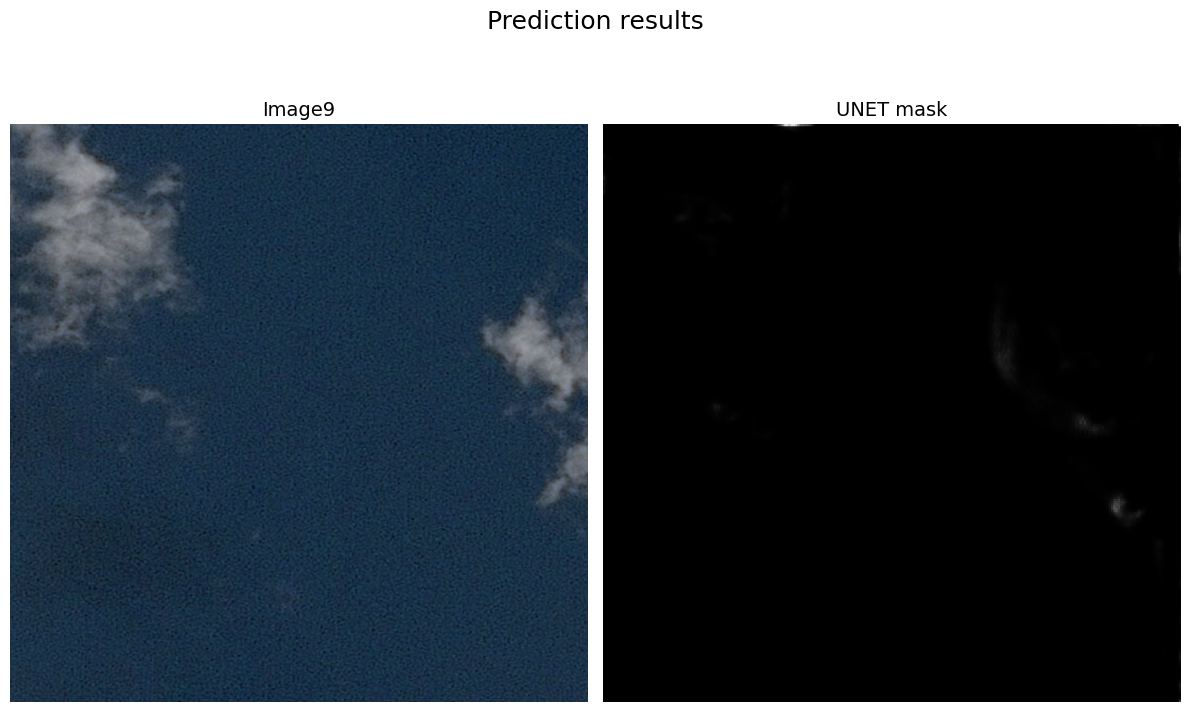

In [148]:
for i, img in enumerate(images_readed):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    fig.suptitle('Prediction results', fontsize=18)

    # plot orig image
    ax[0].imshow(img)
    plot_helper(ax, 0, f"Image{i}")
    
    # plot predicted mask
    mask = masks[i].numpy()
    ax[1].imshow(mask, 'binary_r')
    plot_helper(ax, 1, 'UNET mask')
    fig.tight_layout()

# Conlusions

Model performs well when the entity of the ship is visible. However, if there are challenging structures such as clouds or fog, the model makes a mask for a small part of it as on image8.
Generally, for this task accuracy around 69-70% is OK. But there is a open field for improvements. To improve accuracy we can use data augmentation of images for training samples (rotating, cropping, scaling, etc.), check possible improvements of U-NET using pretrained VGG, ImageNet encoders, changing architecture of U-NET to U-NET+, V-NET UNet-X (placeholder for any additional customization or variation added) or check performace of another architecture like DeepLab, MaskRCNN.